# Notebook de treinamento de redes convolucionais com os dados classificados por especialistas com aumentação de dados

Neste notebook treinamos diversas arquiteturas de redes convolucionais partindo dos pesos da ImageNet. Para este notebook, usamos apenas os dados anotados por especialistas e avaliamos as redes no conjunto de validação. Utilizamos aumentação de dados.

# Base de dados e importações

In [ ]:
!gdown --id 1iNBLFXyiS4kiJkPZJb_9-KO-LRYS4Z7V --output audio_wav_especialistas.zip
!unzip audio_wav_especialistas.zip
!rm -rf audio_wav_especialistas.zip  
!gdown --id 1wG0iOHehIWF38kEpGhuHfFRotBBMC9t_ --output CSV.zip
!unzip CSV.zip

Downloading...
From: https://drive.google.com/uc?id=1iNBLFXyiS4kiJkPZJb_9-KO-LRYS4Z7V
To: /content/audio_wav_especialistas.zip
607MB [00:07, 82.5MB/s]
Archive:  audio_wav_especialistas.zip
   creating: content/audios_expecialistas/
  inflating: content/audios_expecialistas/30fa4631-eba2-44d7-ba44-4ef930092d45.wav  
  inflating: content/audios_expecialistas/9b110ff2-f5c2-4e6e-8bb3-31f502375c7d.wav  
  inflating: content/audios_expecialistas/0b6f8543-c5e3-414c-a4f3-020e56e8ec60.wav  
  inflating: content/audios_expecialistas/c3174535-aaef-4c26-b0b5-a38996e54763.wav  
  inflating: content/audios_expecialistas/46723cf9-49fd-404f-b62f-6ba97019d921.wav  
  inflating: content/audios_expecialistas/2e0e732f-3cf5-4fb6-9762-aae4ab603d4d.wav  
  inflating: content/audios_expecialistas/8debc554-dee0-49c8-8a54-34c26de4190d.wav  
  inflating: content/audios_expecialistas/98e4742a-3aab-4dcb-a5b8-e903f91c4324.wav  
  inflating: content/audios_expecialistas/20638b85-0ab9-45cc-b257-9ce9986946de.wav  
  i

In [ ]:
import pandas as pd
from collections import Counter
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import concurrent.futures
import multiprocessing
import time
import gc
import cv2
import librosa

Foi efetuado o mapeamento das classes que até então era string categórico, para os valores 0, 1 e 2.

*   healthy - 0 
*   symptomatic -  1 
*   COVID-19 - 2

In [ ]:
train = pd.read_csv('/content/CSV/train.csv')
val = pd.read_csv('/content/CSV/val.csv')
train['classInt'] = train['status'].replace(['healthy','symptomatic','COVID-19'], [0, 1, 2])
val['classInt'] = val['status'].replace(['healthy','symptomatic','COVID-19'], [0, 1, 2])
train['classStr'] = train['classInt'].astype('str')
val['classStr'] = val['classInt'].astype('str')
train['uuid'] = train['uuid'] + '.wav'
val['uuid'] = val['uuid'] + '.wav'

Utilizou-se os pesos para cada classe como forma de lidar com o desbalanceamento dos dados.

Ficando dessa forma:

*   healthy -  representado pelo 0 - ficou com o peso 1.3982300884955752
*   symptomatic -  represenatado pelo 1 - ficou com o peso 1.0 
*   COVID-19 - represenatado pelo 2 - ficou com o peso 1.5906040268456376

In [ ]:
# Determinando os pesos
counter = Counter(train['classInt'])  
max_val = float(max(counter.values()))  
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}    
class_weights 

{0: 1.3982300884955752, 1: 1.0, 2: 1.5906040268456376}

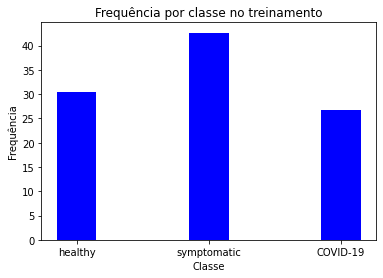

In [ ]:
plt.bar(0, len(train.values[train.classInt.values == 0])/len(train.values) * 100, width=0.3, color='blue')
plt.bar(1, len(train.values[train.classInt.values == 1])/len(train.values) * 100, width=0.3, color='blue')
plt.bar(2, len(train.values[train.classInt.values == 2])/len(train.values) * 100, width=0.3, color='blue')
plt.ylabel('Frequência')
plt.xlabel('Classe')
plt.xticks([0, 1, 2], ['healthy','symptomatic','COVID-19'])
plt.title('Frequência por classe no treinamento')
plt.savefig('Treinamento-especialista.png')

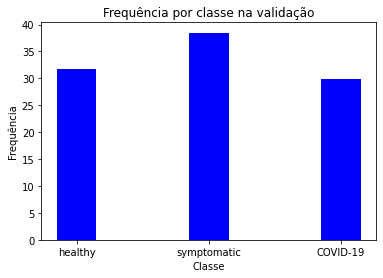

In [ ]:
plt.bar(0, len(val.values[val.classInt.values == 0])/len(val.values) * 100, width=0.3, color='blue')
plt.bar(1, len(val.values[val.classInt.values == 1])/len(val.values) * 100, width=0.3, color='blue')
plt.bar(2, len(val.values[val.classInt.values == 2])/len(val.values) * 100, width=0.3, color='blue')
plt.ylabel('Frequência')
plt.xlabel('Classe')
plt.xticks([0, 1, 2], ['healthy','symptomatic','COVID-19'])
plt.title('Frequência por classe na validação')
plt.savefig('Validacao.png')

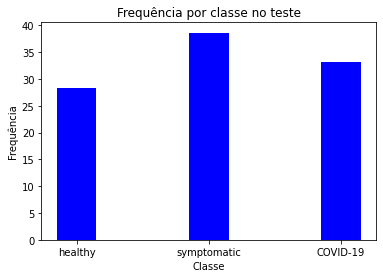

In [ ]:
teste = pd.read_csv('/content/CSV/test.csv')
teste['classInt'] = teste['status'].replace(['healthy','symptomatic','COVID-19'], [0, 1, 2])
plt.bar(0, len(teste.values[teste.classInt.values == 0])/len(teste.values) * 100, width=0.3, color='blue')
plt.bar(1, len(teste.values[teste.classInt.values == 1])/len(teste.values) * 100, width=0.3, color='blue')
plt.bar(2, len(teste.values[teste.classInt.values == 2])/len(teste.values) * 100, width=0.3, color='blue')
plt.ylabel('Frequência')
plt.xlabel('Classe')
plt.xticks([0, 1, 2], ['healthy','symptomatic','COVID-19'])
plt.title('Frequência por classe no teste')
plt.savefig('Teste.png')

# Função para treinamento de modelos

In [ ]:
lista_audios_train = []
label_audios_train = []

for i in train.values:
  lista_audios_train.append('/content/content/audios_expecialistas/' + i[1])
  label_audios_train.append(i[-2])

In [ ]:
lista_audios_val = []
label_audios_val = []

for i in val.values:
  lista_audios_val.append('/content/content/audios_expecialistas/' + i[1])
  label_audios_val.append(i[-2])

In [ ]:
#métodos como base https://www.kaggle.com/huseinzol05/sound-augmentation-librosa
DEBUG_MODE = False
SAMPLE_RATE = 22050

def add_noise(y):
  if (DEBUG_MODE):
    print('add_noise')
  y_noise = y.copy()
  noise_amp = 0.005*np.random.uniform()*np.amax(y_noise)
  y_noise = y_noise.astype('float64') + noise_amp * np.random.normal(size=y_noise.shape[0])
  return y_noise

def add_white_noise(y):
  if (DEBUG_MODE):
    print('add_white_noise')
  wn = np.random.randn(len(y))
  data_wn = y + 0.020*wn
  return wn

def add_harmonic(y):
  if (DEBUG_MODE):
    print('add_harmonic')
  y_harmonic, y_percussive = librosa.effects.hpss(y.astype('float64'))
  return y_harmonic

def add_streching(y):
  if (DEBUG_MODE):
    print('add_streching')
  input_length = len(y)
  streching = y.copy()
  streching = librosa.effects.time_stretch(streching.astype('float'), 1.1)
  if len(streching) > input_length:
    streching = streching[:input_length]
  else:
    streching = np.pad(streching, (0, max(0, input_length - len(streching))), "constant")
  return streching

def change_speed(y):
  if (DEBUG_MODE):
    print('change_speed')
  y_speed = y.copy()
  speed_change = np.random.uniform(low=0.1,high=3)
  tmp = librosa.effects.time_stretch(y_speed.astype('float64'), speed_change)
  minlen = min(y_speed.shape[0], tmp.shape[0])
  y_speed *= 0 
  y_speed[0:minlen] = tmp[0:minlen]
  return y_speed

def add_pitch(y, sample_rate= SAMPLE_RATE):
  if (DEBUG_MODE):
    print('add_pitch')
  y_pitch = y.copy()
  bins_per_octave = 12
  pitch_pm = 2
  pitch_change =  pitch_pm * 2*(np.random.uniform())   
  y_pitch = librosa.effects.pitch_shift(y_pitch.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
  return y_pitch

def nothing(y):
  return y

In [ ]:
def apply_data_augmentation(audio_time_series, conj):
    if conj == 1:
      operation = ['nothing', 'harmonic', 'streching', 'pitch']
    else:
      operation = ['nothing']
    op = np.random.choice(operation)
    sr = 22050
    signal, _ = librosa.load(audio_time_series, sr=sr)
    if op == 'nothing':
      signal = nothing(signal)
    elif op == 'noise':
      signal = add_noise(signal)
    elif op == 'white_noise':
      signal = add_white_noise(signal)
    elif op == 'harmonic':
      signal = add_harmonic(signal)
    elif op == 'streching':
      signal = add_streching(signal)
    elif op == 'speed':
      signal = change_speed(signal)
    elif op == 'pitch':
      signal = add_pitch(signal)
    mel_spect = librosa.feature.melspectrogram(y=signal, sr=sr)
    ms = librosa.power_to_db(mel_spect, ref=np.max)
    a = cv2.normalize(ms, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    a = a.astype(np.uint8)
    a = cv2.cvtColor(a, cv2.COLOR_GRAY2RGB)
    heatmap = cv2.applyColorMap(a, cv2.COLORMAP_INFERNO)
    return heatmap

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_audio, labels, process_function, operation, batch_size=32, dim=(128,128), n_channels=3, n_classes=3, shuffle=True):
        'Initialization'
        #print('Initialization')
        self.dim = dim
        self.batch_size = batch_size 
        self.n_channels = n_channels
        self.list_audio = list_audio
        self.labels = labels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.process_function = process_function
        self.operation = operation
        self.on_epoch_end()
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_audio) / self.batch_size))
        
    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_audio_temp = [self.list_audio[k] for k in indexes]
        labels_temp = [self.labels[k] for k in indexes]

        X, y = self.__data_generation(list_audio_temp, labels_temp)
        return X, y
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_audio))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            

    def __data_generation(self, list_audio_temp, labels_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        iter = []
        for i in range(self.batch_size):
          iter.append(self.operation)

        with concurrent.futures.ThreadPoolExecutor() as executor:
          results = executor.map(apply_data_augmentation, list_audio_temp, iter)
          for i, result in enumerate(results):
            X[i,] = self.process_function(cv2.resize(result, self.dim))
            y[i] = labels_temp[i]

        '''
        for i in range(len(list_audio_temp)):
          a = apply_data_augmentation(list_audio_temp[i], self.operation)
          X[i] = self.process_function(cv2.resize(a, self.dim))
          y[i] = labels_temp[i]
        '''

        return X, tf.keras.utils.to_categorical(y, num_classes=self.n_classes)

In [ ]:
def cria_e_treina_rede(model_name, train_wav, train_label, val_wav, val_label, batch_size=32, callbacks=[], image_size=(128, 128), pooling='avg', loss='categorical_crossentropy', epochs=500, class_weights=class_weights, trainable=True):

  if model_name == 'resnet50' or model_name == 'resnet101' or model_name == 'resnet152':
    preprocessing_function = tf.keras.applications.resnet.preprocess_input
  elif model_name == 'efficientnetb0' or model_name == 'efficientnetb1' or model_name == 'efficientnetb2' or model_name == 'efficientnetb3' or model_name == 'efficientnetb4' or model_name == 'efficientnetb5'  or model_name == 'efficientnetb6' or model_name == 'efficientnetb7':
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
  elif model_name == 'mobilenet':
    preprocessing_function = tf.keras.applications.mobilenet.preprocess_input
  elif model_name == 'mobilenetv2':
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input
  elif model_name == 'densenet121' or model_name == 'densenet169' or model_name == 'densenet201':
    preprocessing_function = tf.keras.applications.densenet.preprocess_input
  elif model_name == 'inceptionv3':
    preprocessing_function = tf.keras.applications.inception_v3.preprocess_input
  elif model_name == 'inceptionresnetv2':
    preprocessing_function = tf.keras.applications.inception_resnet_v2.preprocess_input
  elif model_name == 'xception':
    preprocessing_function = tf.keras.applications.xception.preprocess_input
  elif model_name == 'vgg16':
    preprocessing_function = tf.keras.applications.vgg16.preprocess_input
  elif model_name == 'vgg19':
    preprocessing_function = tf.keras.applications.vgg19.preprocess_input

  train_generator = DataGenerator(train_wav, train_label, preprocessing_function, 1)
  val_generator = DataGenerator(val_wav, val_label, preprocessing_function, 2)

  if model_name == 'resnet50':
    pre_trained = tf.keras.applications.ResNet50(include_top=False, pooling=pooling)
  elif model_name == 'resnet101':
    pre_trained = tf.keras.applications.ResNet101(include_top=False, pooling=pooling)
  elif model_name == 'resnet152':
    pre_trained = tf.keras.applications.ResNet152(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb0':
    pre_trained = tf.keras.applications.EfficientNetB0(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb1':
    pre_trained = tf.keras.applications.EfficientNetB1(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb2':
    pre_trained = tf.keras.applications.EfficientNetB2(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb3':
    pre_trained = tf.keras.applications.EfficientNetB3(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb4':
    pre_trained = tf.keras.applications.EfficientNetB4(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb5':
    pre_trained = tf.keras.applications.EfficientNetB5(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb6':
    pre_trained = tf.keras.applications.EfficientNetB6(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb7':
    pre_trained = tf.keras.applications.EfficientNetB7(include_top=False, pooling=pooling)
  elif model_name == 'mobilenet':
    pre_trained = tf.keras.applications.MobileNet(include_top=False, pooling=pooling)
  elif model_name == 'mobilenetv2':
    pre_trained = tf.keras.applications.MobileNetV2(include_top=False, pooling=pooling)
  elif model_name == 'densenet121':
    pre_trained = tf.keras.applications.DenseNet121(include_top=False, pooling=pooling)
  elif model_name == 'densenet169':
    pre_trained = tf.keras.applications.DenseNet169(include_top=False, pooling=pooling)
  elif model_name == 'densenet201':
    pre_trained = tf.keras.applications.DenseNet201(include_top=False, pooling=pooling)
  elif model_name == 'inceptionv3':
    pre_trained = tf.keras.applications.InceptionV3(include_top=False, pooling=pooling)
  elif model_name == 'inceptionresnetv2':
    pre_trained = tf.keras.applications.InceptionResNetV2(include_top=False, pooling=pooling)
  elif model_name == 'xception':
    pre_trained = tf.keras.applications.Xception(include_top=False, pooling=pooling)
  elif model_name == 'vgg16':
    pre_trained = tf.keras.applications.VGG16(include_top=False, pooling=pooling)
  elif model_name == 'vgg19':
    pre_trained = tf.keras.applications.VGG19(include_top=False, pooling=pooling)

  for layer in pre_trained.layers:
    layer.treinable = trainable

  model = tf.keras.models.Sequential([
   pre_trained,
   tf.keras.layers.Dense(3, activation='softmax')
  ])

  model.summary()

  optimizer = tf.keras.optimizers.Adam(0.000001)

  model.compile(loss=loss, optimizer=optimizer, metrics=['acc'])

  list_of_callbacks = []
  if 'earlystopping' in callbacks:
    list_of_callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode="min", restore_best_weights=True, verbose=1))
  if 'reducelr' in callbacks:
    list_of_callbacks.append(tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, mode="min", verbose=1))
  if 'checkpoint' in callbacks:
    list_of_callbacks.append(tf.keras.callbacks.ModelCheckpoint('/content/' + model_name + '.hdf5', save_best_only=True, verbose=1))

  history = model.fit(train_generator, validation_data=val_generator, batch_size=batch_size, class_weight=class_weights, callbacks=list_of_callbacks, epochs=epochs)

  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title(model_name + ' accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(model_name + ' loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  predict_val = model.predict(val_generator, verbose=1)
  y_true = []

  i = 0
  for batch, label in val_generator:
    i += batch.shape[0]
    for l in np.argmax(label, axis=1):
      y_true.append(l)
    if i == len(val_wav): break

  y_true = np.array(y_true)

  print(confusion_matrix(y_true, np.argmax(predict_val, axis=1)))

  cm = confusion_matrix(y_true, np.argmax(predict_val, axis=1))
  cm = cm / cm.astype(np.float).sum(axis=1, keepdims=True)
  balanced_acc = np.trace(cm) / 3
  print('Acuracia balanceada na validacao:', balanced_acc)

  return model

# Modelos

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb1 (Functional)  (None, 1280)              6575239   
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 3843      
Total params: 6,579,082
Trainable params: 6,517,027
Non-trainable params: 62,055
_________________________________________________________________
Epoch 1/500
34/34 [==============================] - 217s 6s/step - loss: 1.5915 - acc: 0.3750 - val_loss: 1.1954 - val_acc: 0.3320
Epoch 2/500
34/34 [==============================] - 213s 6s/step - loss: 1.6073 - acc: 0.3529 - val_loss: 1.1778 - val_acc: 0.3594
Epoch 3/500
34/34 [==============================] - 222s 7s/step - loss: 1.6026 - acc: 0.3722 - val_loss: 1.1442 - val_acc: 0.3320
Epoch 4/500
34/34 [==============================] - 220s 6s/step - loss: 1.6007 - acc: 0.3658 - val_loss

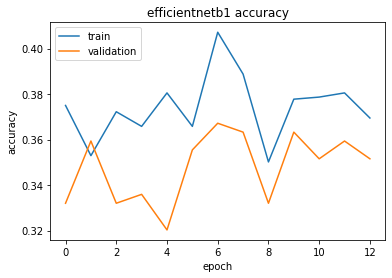

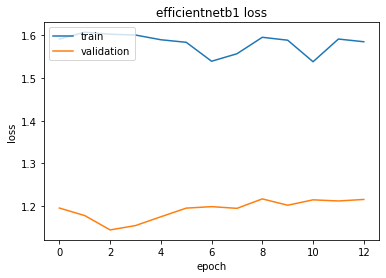

8/8 [==============================] - 6s 569ms/step
[[16 25 39]
 [12 42 48]
 [18 31 25]]
Acuracia balanceada na validacao: 0.3165341812400636


In [ ]:
eff1 = cria_e_treina_rede('efficientnetb1', lista_audios_train, label_audios_train, lista_audios_val, label_audios_val, callbacks=['earlystopping', 'reducelr'])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Functional)  (None, 2560)              64097687  
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 7683      
Total params: 64,105,370
Trainable params: 63,794,643
Non-trainable params: 310,727
_________________________________________________________________
Epoch 1/500
34/34 [==============================] - 254s 7s/step - loss: 1.4531 - acc: 0.3382 - val_loss: 1.1255 - val_acc: 0.3438
Epoch 2/500
34/34 [==============================] - 220s 6s/step - loss: 1.4387 - acc: 0.3493 - val_loss: 1.1432 - val_acc: 0.3047
Epoch 3/500
34/34 [==============================] - 221s 6s/step - loss: 1.4425 - acc: 0.3401 - val_loss: 1.1617 - val_acc: 0.2773
Epoch 4/500
34/34 [==============================] - 223s 7s/step - loss: 1.4275 - acc: 0.3658 - val_l

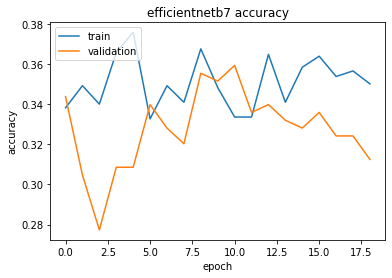

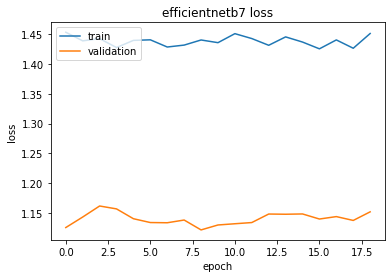

8/8 [==============================] - 9s 595ms/step
[[25 30 26]
 [42 33 28]
 [27 20 25]]
Acuracia balanceada na validacao: 0.3254175156818091


In [ ]:
eff7 = cria_e_treina_rede('efficientnetb7', lista_audios_train, label_audios_train, lista_audios_val, label_audios_val, callbacks=['earlystopping', 'reducelr'])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 1664)              12642880  
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 4995      
Total params: 12,647,875
Trainable params: 12,489,475
Non-trainable params: 158,400
_________________________________________________________________
Epoch 1/500
34/34 [==============================] - 227s 6s/step - loss: 1.9570 - acc: 0.4007 - val_loss: 1.1846 - val_acc: 0.4062
Epoch 2/500
34/34 [==============================] - 215s 6s/step - loss: 1.8917 - acc: 0.4099 - val_loss: 1.2208 - val_acc: 0.3789
Epoch 3/500
34/34 [==============================] - 207s 6s/step - loss: 1.9456 - acc: 0.3722 - val_loss: 1.2346 - val_acc: 0.3750
Epoch 4/500
34/34 [==============================] - 213s 6s/step - loss: 1.8883 - acc: 0.3824 - val_l

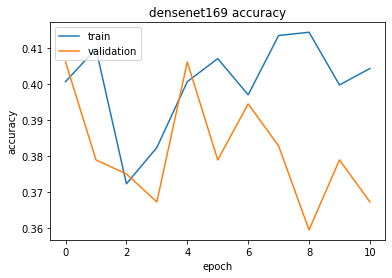

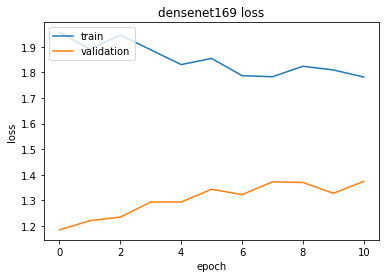

8/8 [==============================] - 7s 595ms/step
[[17 58  6]
 [34 56  8]
 [23 49  5]]
Acuracia balanceada na validacao: 0.28208005985783763


In [ ]:
d169 = cria_e_treina_rede('densenet169', lista_audios_train, label_audios_train, lista_audios_val, label_audios_val, callbacks=['earlystopping', 'reducelr'])

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 6147      
Total params: 21,808,931
Trainable params: 21,774,499
Non-trainable params: 34,432
_________________________________________________________________
Epoch 1/500
34/34 [==============================] - 233s 7s/step - loss: 1.5914 - acc: 0.3061 - val_loss: 1.9031 - val_acc: 0.2891
Epoch 2/500
34/34 [==============================] - 213s 6s/step - loss: 1.5878 - acc: 0.3153 - val_loss: 1.5351 - val_acc: 0.3008
Epoch 3/500
34/34 [==============================] - 221s 7s/step - loss: 1.5782 - acc: 0.3162 - val_loss: 1.4412 - val_acc: 0.2773
Epoch 4/500
34/34 [==============================] - 220s 6s/step - loss: 1.5872 - acc: 0.3042 - val_lo

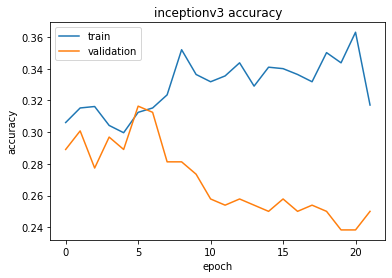

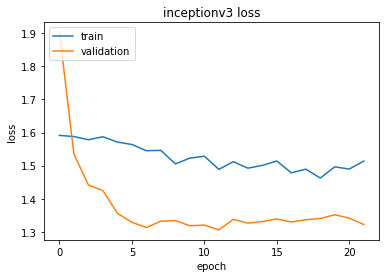

8/8 [==============================] - 6s 588ms/step
[[10 16 54]
 [26 20 55]
 [12 17 46]]
Acuracia balanceada na validacao: 0.3121177117711771


In [ ]:
iv3 = cria_e_treina_rede('inceptionv3', lista_audios_train, label_audios_train, lista_audios_val, label_audios_val, callbacks=['earlystopping', 'reducelr'])

80142336/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 512)               20024384  
_________________________________________________________________
dense (Dense)                (None, 3)                 1539      
Total params: 20,025,923
Trainable params: 20,025,923
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/500
34/34 [==============================] - 202s 5s/step - loss: 4.3586 - acc: 0.3502 - val_loss: 2.3175 - val_acc: 0.3398
Epoch 2/500
34/34 [==============================] - 206s 6s/step - loss: 3.0608 - acc: 0.3548 - val_loss: 1.9025 - val_acc: 0.3281
Epoch 3/500
34/34 [====================

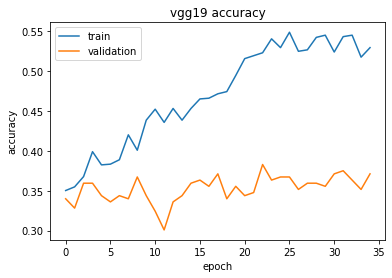

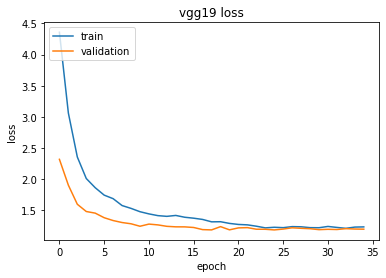

8/8 [==============================] - 5s 560ms/step
[[17 32 32]
 [27 37 34]
 [22 20 35]]
Acuracia balanceada na validacao: 0.3473243393878314


In [ ]:
vgg19 = cria_e_treina_rede('vgg19', lista_audios_train, label_audios_train, lista_audios_val, label_audios_val, callbacks=['earlystopping', 'reducelr'])